# 🚨 Cybersecurity Anomaly Detection Workflow

This notebook outlines a comprehensive workflow for detecting suspicious activities within logs using advanced machine learning techniques applied to the BETH dataset.

The dataset, as discussed in the article [<<article_name>>], serves as the foundation for preprocessing and performance comparison.

## 📚 Libraries

- Utilizing essential data science, machine learning, and natural language processing packages for a robust analysis.
- Downloading the punkt tokenization module to enhance natural language processing capabilities.


In [1]:
import ast
import re
from pathlib import Path
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from gensim.models import Word2Vec
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import OneClassSVM
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchmetrics import AUROC

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
experiment_name = "beth_anomaly_detection"
mlflow.set_experiment(experiment_name=experiment_name)
mlflow.autolog()

2024/02/24 12:06:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/02/24 12:06:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    print(f"Number of GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i + 1}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

Number of GPUs: 1
GPU 1: NVIDIA GeForce GTX 1060 6GB


In [4]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/haim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
%%writefile datamodules/beth_datareader.py
import pandas as pd


def read_data() -> set[pd.DataFrame]:
    """
    Read in the data from the csv files.
    Args:
        None

    Returns:
        train_df (pd.DataFrame): The training data.
        val_df (pd.DataFrame): The validation data.
        test_df (pd.DataFrame): The testing data.
    """
    train_df = pd.read_csv("data/labelled_training_data.csv")
    val_df = pd.read_csv("data/labelled_validation_data.csv")
    test_df = pd.read_csv("data/labelled_testing_data.csv")
    return train_df, val_df, test_df

Writing datamodules/beth_datareader.py


## 📊 Exploratory Data Analysis (EDA)

Commencing the analysis by opening and consolidating all data files.

The objectives are two-fold:
1. Gain an intuitive understanding of the dataset.
2. Validate the consistency across the train-validation-test datasets, ensuring minimal discrepancies.


In [6]:
from datamodules.beth_datareader import read_data
train_df, val_df, test_df = read_data()
train_df["source"] = "Train set"
val_df["source"] = "Validation set"
test_df["source"] = "Test set"
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
combined_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil,source
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0,Train set
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0,Train set
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0,Train set
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0,Train set
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0,Train set


In [7]:
def plot_by_source(x: str, kind: str) -> None:
    """
    Plots a frequency distribution by data source.
    Hue (color) by "source" column.
    Args:
        x (str): The column to plot.
        kind (str): The type of plot to generate.
            Options: "hist", "kde", "ecdf"

    Returns:
        None
    """
    plot = sns.displot(combined_df, x=x, kind=kind)
    plot.set(
        title=f"{x} Frequency by data source",
        xlabel=x,
        ylabel="Frequency",
        hue=
    )

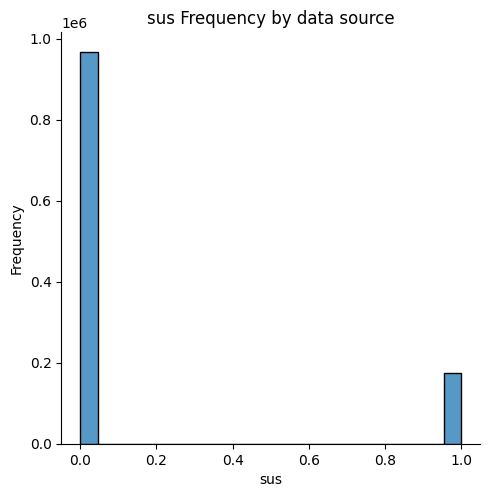

In [8]:
plot_by_source(
    x="sus",
    kind="hist",
)

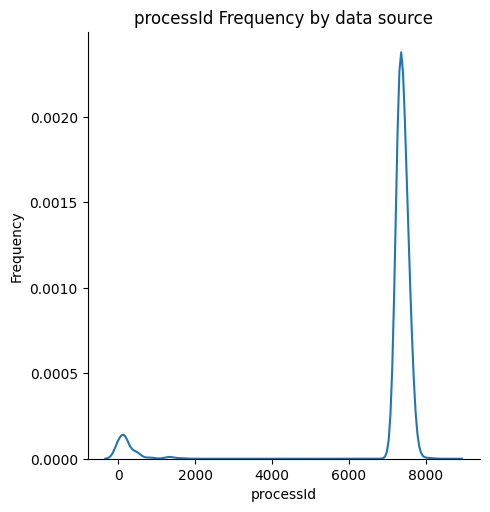

In [9]:
plot_by_source(
    x="processId",
    kind="kde",
)

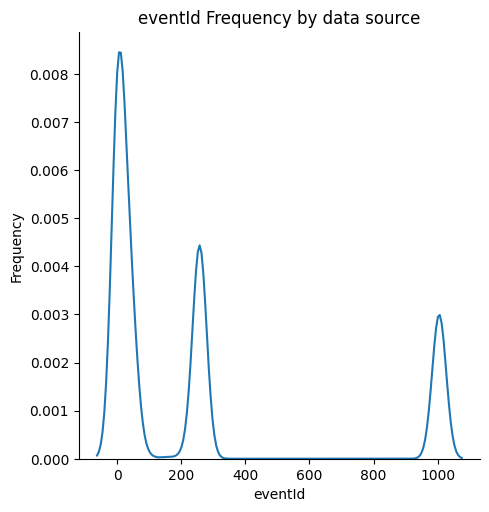

In [10]:
plot_by_source(
    x="eventId",
    kind="kde",
)

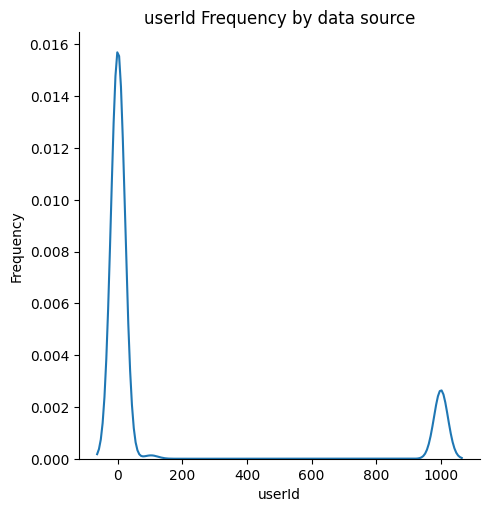

In [11]:
plot_by_source(
    x="userId",
    kind="kde",
)

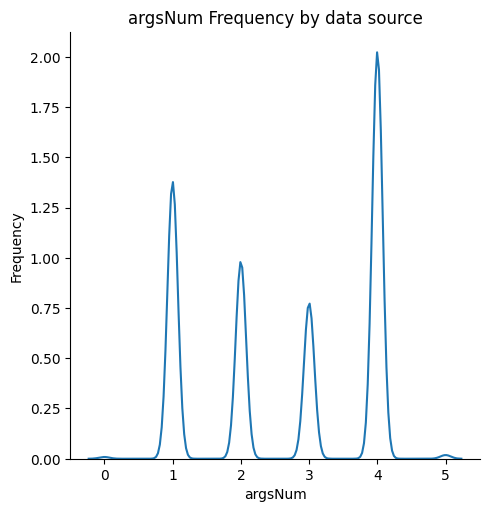

In [12]:
plot_by_source(
    x="argsNum",
    kind="kde",
)

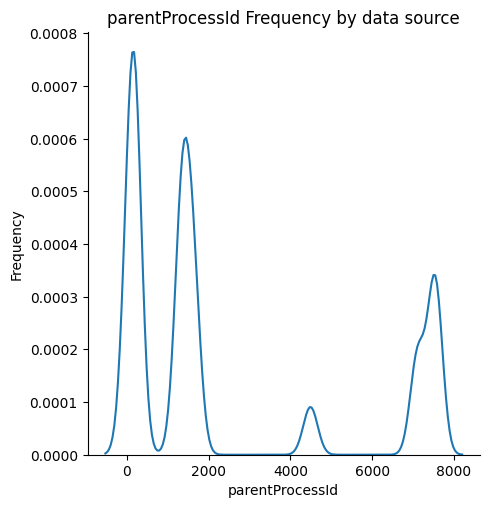

In [13]:
plot_by_source(
    x="parentProcessId",
    kind="kde",
)

In [14]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
timestamp,1141078.0,1.367449e+03,1154.433376,1.244392e+02,4.612974e+02,9.033516e+02,2.327305e+03,3.954588e+03
processId,1141078.0,6.909070e+03,1816.699147,1.000000e+00,7.301000e+03,7.366000e+03,7.461000e+03,8.619000e+03
threadId,1141078.0,6.913038e+03,1807.393062,1.000000e+00,7.301000e+03,7.366000e+03,7.461000e+03,8.619000e+03
parentProcessId,1141078.0,2.467229e+03,2862.639715,0.000000e+00,1.870000e+02,1.385000e+03,4.489000e+03,7.672000e+03
userId,1141078.0,1.437311e+02,350.094691,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.001000e+03
mountNamespace,1141078.0,4.026532e+09,172.669668,4.026532e+09,4.026532e+09,4.026532e+09,4.026532e+09,4.026532e+09
eventId,1141078.0,2.372977e+02,354.831933,2.000000e+00,4.000000e+00,4.200000e+01,2.570000e+02,1.010000e+03
argsNum,1141078.0,2.671557e+00,1.250393,0.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
returnValue,1141078.0,3.018248e+00,322.346826,-1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,3.276800e+04
sus,1141078.0,1.520615e-01,0.359081,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [15]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141078 entries, 0 to 1141077
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   timestamp        1141078 non-null  float64
 1   processId        1141078 non-null  int64  
 2   threadId         1141078 non-null  int64  
 3   parentProcessId  1141078 non-null  int64  
 4   userId           1141078 non-null  int64  
 5   mountNamespace   1141078 non-null  int64  
 6   processName      1141078 non-null  object 
 7   hostName         1141078 non-null  object 
 8   eventId          1141078 non-null  int64  
 9   eventName        1141078 non-null  object 
 10  stackAddresses   1141078 non-null  object 
 11  argsNum          1141078 non-null  int64  
 12  returnValue      1141078 non-null  int64  
 13  args             1141078 non-null  object 
 14  sus              1141078 non-null  int64  
 15  evil             1141078 non-null  int64  
 16  source           1

In [16]:
combined_df.isna().sum()

timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
stackAddresses     0
argsNum            0
returnValue        0
args               0
sus                0
evil               0
source             0
dtype: int64

In [17]:
a = test_df["sus"] == test_df["evil"]
print("Accuracy of sus == evil in test set:\n", sum(a) / len(a) * 100)

Accuracy of sus == evil in test set:
 93.10620372869337


In [18]:
numerical_columns = combined_df.select_dtypes(
    include="number"
).columns.tolist()
non_numerical_columns = combined_df.select_dtypes(
    exclude="number"
).columns.tolist()

### Numerical Features

In [19]:
numerical_columns

['timestamp',
 'processId',
 'threadId',
 'parentProcessId',
 'userId',
 'mountNamespace',
 'eventId',
 'argsNum',
 'returnValue',
 'sus',
 'evil']

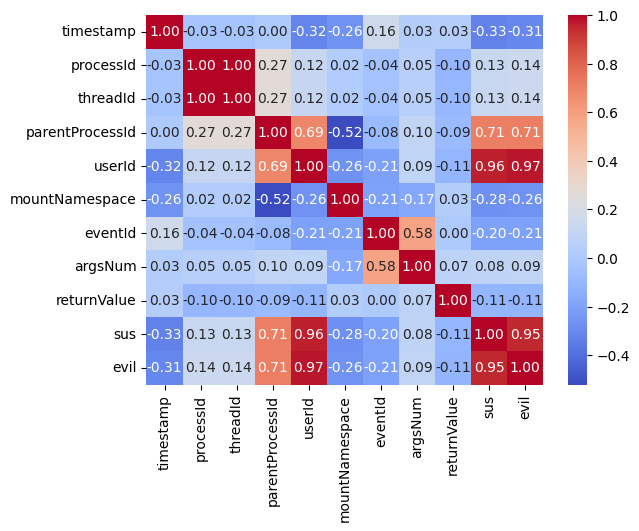

In [20]:
sns.heatmap(
    combined_df.select_dtypes(include="number").corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.savefig("heatmap.jpg")
plt.show()

##### ProcessID & ThreadID Clarification
While these features appear identical in their correlations, it's important to note that this similarity is probably a result of the rounding format.

In [21]:
combined_df[combined_df["processId"] != combined_df["threadId"]][
    ["processId", "threadId"]
]

,processId,threadId
0,381,7337
1,381,7337
2,381,7337
36,381,7423
37,381,7423
...,...,...
992260,7555,7701
992261,7555,7702
992262,7555,7703
992263,7555,7704


In [22]:
plt.clf()

<Figure size 640x480 with 0 Axes>

## 👷 Building the Pipeline
#### 🔍 Feature Descrptipons
* **Timestamp:** As suggested by the authors, we aim to consider the dataset as samples and not as a timeseries, so it can be left out.

* **ProcessID & ParentProcessID:** Values are encoded, not numerically meaningful.
    - Values 0, 1, 2 represent OS processes.
    - Other values are random and can be transformed into binary, True/False columns.

* **ThreadID:** This feature is identical to ProcessID unless the process uses multithreading.
    - Binary encoding is suggested, representing whether it is identical to the Process ID or not.

* **UserId:** The system default behavior is to assign system/OS 'users' with a value below 1000 and logged-in users with values 1000 or above. Two ideas:
    - Binary encoding for <1000 and >= 1000.
    - Divide the value by 1000. This way, we retain more information while still distinguishing systems and logged-in users (0 to 1 vs. above 1).

In [23]:
def transform_process_ids(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transform ProcessID & ParentProcessID into binary columns.
    Values 0, 1, 2 represent OS processes, while others are random values.
    Args:
        data (pd.DataFrame): Input dataframe with 'ProcessID' and
        'ParentProcessID' columns.

    Returns:
        pd.DataFrame: Transformed Dataframe with 'IsOSProcess' and
        'IsOSParentProcess' binary columns.
    """

    data["isOSProcess"] = np.where(data["processId"].isin([0, 1, 2]), 1.0, 0.0)
    data["isOSParentProcess"] = np.where(
        data["parentProcessId"].isin([0, 1, 2]), True, False
    )
    return data


def transform_thread_id(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transform ThreadID into a binary column.
    ThreadID is identical to ProcessID unless the process uses multithreading.
    Args:
        data (pd.DataFrame): Input dataframe with 'ThreadID' and 'ProcessID'
        columns.

    Returns:
        pd.DataFrame: Transformed dataframe with 'IsIdenticalThreadID' binary
        column.
    """
    data["isIdenticalThreadId"] = np.where(
        data["threadId"] == data["processId"], True, False
    )
    return data


def transform_user_id(data: pd.DataFrame) -> pd.DataFrame:
    """
    Binary encode UserId based on the suggested criteria.
    UserId below 1000 represents system/os users, and 1000 or above represents
    logged-in users.
    Args:
        data (pd.DataFrame): Input dataframe with 'UserId' column.

    Returns:
        pd.DataFrame: Transformed dataframe with 'IsSystemUser' and
        'IsLoggedInUser' binary columns.
    """
    data["isLoggedInUser"] = data["userId"] >= 1000
    data["transformedUserId"] = data["userId"] / 1000
    return data


def transform_mount_namespace(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transform MountNamespace into a binary column.
    Args:
        data (pd.DataFrame): Input dataframe with 'MountNamespace' column.

    Returns:
        pd.DataFrame: Transformed dataframe with 'IsMountNamespace' binary
        column.
    """
    data["mountedMntDir"] = data["mountNamespace"] == 4026531840
    return data

"Log transform" 🙃

In [24]:
numerical_column_transforms = [
    (
        "process_ids",
        FunctionTransformer(transform_process_ids, validate=False),
    ),
    (
        "thread_id",
        FunctionTransformer(transform_thread_id, validate=False),
    ),
    (
        "user_id",
        FunctionTransformer(transform_user_id, validate=False),
    ),
    (
        "mount_space",
        FunctionTransformer(transform_mount_namespace, validate=False),
    ),
]

### Non-numerical Features

In [25]:
non_numerical_columns

['processName', 'hostName', 'eventName', 'stackAddresses', 'args', 'source']

In [26]:
a = np.unique([len(x) for x in combined_df["stackAddresses"]])
print(a, len(a))

[  2  17  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  62  63  64  65  66  68  69  70  71  72  73  78  84
  85  88  91 100 101 104 105 116 122 128 132 141 144 160 176 192 224 240
 256 272 320 321 339 340] 78


In [27]:
def list_length_transformer(data: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a new column with the length of the stackAddresses.
    Args:
        data (pd.DataFrame): The data to transform.
    Returns:
        pd.DataFrame: The transformed data.
    """
    data["list_length"] = data["stackAddresses"].apply(len)
    return data

In [28]:
categorical_column_transforms = [
    (
        "list_length",
        FunctionTransformer(list_length_transformer, validate=False),
    ),
]

In [29]:
class ArgsEmbeddingTransformer(BaseEstimator, TransformerMixin):
    """
    This transformer class takes an "args" column and transforms it into an
    embedded sentence vector column of those argtuments.
    The training (fit) step trains a word2vec model on those args, and the
    transform step uses the trained model to embed the args.
    """

    def preprocess_args_string(self, args_string: str) -> list[str]:
        """
        Preprocess the arguments string to tokenize it into words.
        1. Extracts the argument values, removing data types
        2. Clears characters added by the encoding (these are not part of the
        args).
        Args:
            args_string (str): The arguments string to preprocess.

        Returns:
            list: A list of words from the arguments string.
        """
        args_string = str(
            {
                arg["name"]: arg["value"]
                for arg in ast.literal_eval(args_string)
            }
        )
        cleaned_args = re.sub(r"[\[\]{}':,]", "", args_string).lstrip()
        return word_tokenize(cleaned_args)

    def train_word2vec_model(self, X):
        """
        Train a word2vec model on the arguments strings.
        Args:
            X (DataFrame): The DataFrame containing the arguments strings.

        Returns:
            Word2Vec: The trained word2vec model.
        """
        word2vec_model = Word2Vec(
            sentences=X["tokenizedArgs"],
            vector_size=50,
            window=5,
            min_count=1,
            workers=6,
            seed=1337,
        )
        self.word2vec_model = word2vec_model

    def get_sentence_vector(self, sentence):
        """
        Get the average word2vec vector for a sentence.
        Args:
            sentence (list): The list of words in the sentence.

        Returns:
            numpy.ndarray: The average word2vec vector for the sentence.
        """
        vectors = [
            self.word2vec_model.wv[word]
            for word in sentence
            if word in self.word2vec_model.wv
        ]
        return sum(vectors) / len(vectors) if vectors else None

    def fit(self, X, y=None):
        """
        Fit the ArgsTokenizerTransformer to the training data.
        Args:
            X (DataFrame): The DataFrame containing the arguments strings.
            y (None): Not used.

        Returns:
            ArgsTokenizerTransformer: The fitted ArgsTokenizerTransformer.
        """
        X_copy = X.copy()
        X_copy["tokenizedArgs"] = X_copy["args"].apply(
            self.preprocess_args_string
        )
        self.train_word2vec_model(X_copy)
        return self

    def fillna_embeddings(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Fills in the missing embeddings with zeros.
        Args:
            data (pd.DataFrame): The DataFrame to fill in the missing embeddings.
        Returns:
            pd.DataFrame: The DataFrame with filled in missing embeddings.
        """
        data["embedding"] = data["embedding"].apply(
            lambda x: np.zeros(50, dtype=np.float32) if x is None else x
        )
        return data

    def transform(self, X):
        """
        Transform the arguments strings into word2vec vectors.
        Args:
            X (DataFrame): The DataFrame containing the arguments strings.

        Returns:
            DataFrame: The DataFrame with the word2vec vectors added.
        """
        X_copy = X.copy()
        if "tokenizedArgs" not in X_copy.columns:
            X_copy["tokenizedArgs"] = X_copy["args"].apply(
                self.preprocess_args_string
            )
        X_copy["embedding"] = X_copy["tokenizedArgs"].apply(
            self.get_sentence_vector
        )
        X_copy = self.fillna_embeddings(X_copy)
        return X_copy

In [30]:
def embedding_to_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms an embedding column into a dataframe and concatenates it to the
    original dataframe.
    Drops the embedding column.
    Args:
        data (pd.DataFrame): Dataframe with embeddings.

    Returns:
        pd.DataFrame: Dataframe with embeddings concatenated.
    """
    embeddings = np.vstack(data["embedding"])
    embeddings_df = pd.DataFrame(embeddings)
    data = pd.concat([data, embeddings_df], axis=1)
    data.columns = data.columns.astype(str)
    return data.drop(columns=["embedding"])

In [31]:
args_to_embedding_transformer = [
    ("args_tokenizer", ArgsEmbeddingTransformer()),
    (
        "embedding_to_columns",
        FunctionTransformer(embedding_to_columns, validate=False),
    ),
]

In [32]:
columns_to_drop = [
    "processId",
    "parentProcessId",
    "threadId",
    "userId",
    "stackAddresses",
    "mountNamespace",
    "timestamp",
    "processName",
    "eventName",
    "hostName",
    "args",
    "tokenizedArgs",
]


def transform_drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Drop pre-transformation columns and columns that are not needed for
    training.
    Args:
        data (pd.DataFrame): Input dataframe.

    Returns:
        pd.DataFrame: Transformed dataframe with dropped columns.
    """
    data = data.drop(columns=columns_to_drop)
    return data


drop_columns_transformer = [
    (
        "drop_columns",
        FunctionTransformer(transform_drop_columns, validate=False),
    )
]

In [33]:
pipeline = Pipeline(
    numerical_column_transforms
    + categorical_column_transforms
    + args_to_embedding_transformer
    + drop_columns_transformer
)

* Take the embedded column and turn it into a stacked numpy array, concatenate to the df from the right
* Cast all values into np.float32
* Check if we can use sparse matrix
* Separate "sus" & "evil" from X dataframe to a y dataframe
* Run models

In [34]:
# embeddings = transformed_df["embedding"]
# temp_df = transformed_df.drop(columns=["embedding"])
# len(cleaned_embeddings) == len(temp_df)
# pca = PCA(n_components=2)
# print(np.cumsum(pca.explained_variance_ratio_))
# pca_result = pca.fit_transform(cleaned_embeddings)
# pca_df = pd.DataFrame(
#     data={
#         "PCA1": pca_result[:, 0],
#         "PCA2": pca_result[:, 1],
#         "sus": transformed_df["sus"],
#     }
# )
# sns.scatterplot(
#     x="PCA1", y="PCA2", hue="sus", data=pca_df, palette={1: "red", 0: "blue"}
# )

## 🏃🏻‍♂️ Running the datasets through the pipeline

In [35]:
train_df, val_df, test_df = read_data()

In [37]:
mlflow.autolog(disable=True)
transformed_train_df = pipeline.fit_transform(train_df)
y_train = transformed_train_df["sus"]
X_train = transformed_train_df.drop(columns=["sus", "evil"])
X_column_names = X_train.columns

transformed_val_df = pipeline.transform(val_df)
y_val = transformed_val_df["sus"]
X_val = transformed_val_df.drop(columns=["sus", "evil"])

transformed_test_df = pipeline.transform(test_df)
y_test = transformed_test_df["sus"]
X_test = transformed_test_df.drop(columns=["sus", "evil"])

In [41]:
output_directory = Path("data/np_arrays")
output_directory.mkdir(parents=True, exist_ok=True)
np.save(output_directory / "X_column_names.npy", np.array(X_column_names))
datasets = [
    ("X_train.npy", X_train),
    ("y_train.npy", y_train),
    ("X_val.npy", X_val),
    ("y_val.npy", y_val),
    ("X_test.npy", X_test),
    ("y_test.npy", y_test),
]

for filename, data in datasets:
    np.save(output_directory / filename, data, allow_pickle=True)

In [ ]:
exit()

## 🏋️ Model Training
### 🌲 Isolation Forest

In [ ]:
iforest_model = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    random_state=1337,
)
iforest_model.fit(X_train, y_train)
y_hat = iforest_model.predict(X_val)
y_hat = anomaly_results_to_binary(y_hat)
auroc = roc_auc_score(y_val, y_hat)
print(auroc)

### ↗️ One-Class Support Vector Machine

In [ ]:
one_class_svm_model = OneClassSVM(
    kernel="linear",
)
one_class_svm_model.fit(X_train, y_train)
y_hat = one_class_svm_model.predict(X_val)
auroc = roc_auc_score(y_val, y_hat)
print(auroc)

### ⚡️ Artificial Neural Network

In [43]:
%%writefile datamodules/beth_datamodule.py

import torch
from torch.utils.data import DataLoader, Dataset
import lightning as L


class BETHTorchDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

class BETHDataModule(L.LightningDataModule):
    def __init__(
        self,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        X_test=None,
        y_test=None,
        batch_size=32,
        num_workers=2,
    ):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.setup()

    def setup(self, stage=None):
        self.train_dataset = BETHTorchDataset(self.X_train, self.y_train)
        self.val_dataset = BETHTorchDataset(self.X_val, self.y_val)
        self.test_dataset = BETHTorchDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )


Overwriting datamodules/beth_datamodule.py


In [ ]:
datamodule = BETHDataModule(
    X_train.to_numpy(dtype=np.float32),
    y_train.to_numpy(dtype=np.float32),
    X_val.to_numpy(dtype=np.float32),
    y_val.to_numpy(dtype=np.float32),
    batch_size=512,
)

In [45]:
%%writefile models/ann.py

import torch.nn as nn
import torch.optim as optim
from pytorch_lightning import LightningModule
from torchmetrics import AUROC


class ANN(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.metric = AUROC("binary")
        self.loss_fn = nn.BCELoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

    def _step(self, batch, batch_idx):
        inputs, labels = batch
        y_hat = self(inputs)
        loss = self.loss_fn(y_hat, labels.unsqueeze(1))
        auroc = self.metric(y_hat, labels)
        return loss, auroc

    def training_step(self, batch, batch_idx):
        train_loss, train_auroc = self._step(batch, batch_idx)
        self.log("train_loss", train_loss, on_epoch=True)
        self.log("train_auroc", train_auroc, on_epoch=True)
        return train_loss

    def validation_step(self, batch, batch_idx):
        val_loss, val_auroc = self._step(batch, batch_idx)
        self.log("val_loss", val_loss, on_epoch=True)
        self.log("val_auroc", val_auroc, on_epoch=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        test_loss, test_auroc = self._step(batch, batch_idx)
        self.log("test_loss", test_loss, on_epoch=True)
        self.log("test_auroc", test_auroc, on_epoch=True)
        return test_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

Writing models/ann.py


In [ ]:
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 216])
    batch_size = trial.suggest_categorical(
        "batch_size", [16, 32, 64, 128, 216, 512, 1024]
    )
    learning_rate = trial.suggest_loguniform("learning_rate", 3e-5, 3e-3)
    model = ANN(60, hidden_dim, 1, learning_rate=learning_rate)

    tb_logger = TensorBoardLogger(save_dir="tb_logs_overnight", name="ANN")
    datamodule = BETHDataModule(
        X_train.to_numpy(dtype=np.float32),
        y_train.to_numpy(dtype=np.float32),
        X_val.to_numpy(dtype=np.float32),
        y_val.to_numpy(dtype=np.float32),
        batch_size=batch_size,
    )
    trainer = L.Trainer(
        logger=tb_logger,
        fast_dev_run=False,
        max_epochs=75,
        accelerator="gpu",
        devices=1,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                min_delta=0.00001,
                patience=5,
                verbose=True,
                mode="min",
            )
        ],
    )
    hyperparameters = dict(
        hidden_dim=hidden_dim,
        batch_size=batch_size,
        learning_rate=learning_rate,
    )
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=datamodule)

    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=60 * 60 * 8)

print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")